# Sandbox for testing FastSurfer model
- https://github.com/nikhil153/FastSurfer

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask import compute, delayed
import dask.multiprocessing


### Paths

In [2]:
project_dir = '../'
results_dir = '{}results/FastSurfer/'.format(project_dir)

In [3]:
def convert_mgh_to_nifti(mgh_file):
    nii_file = mgh_file.rsplit('.',1)[0] + '.nii.gz'
    mgh = nib.load(mgh_file)
    nib.save(mgh, nii_file)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = np.mean((2. * intersection + smooth)/(union + smooth))
    return dice

def get_multi_label_dice(label_list, y_true, y_pred):
    ''' Calculates label-wise dice score for a 3D segmentation volume
    '''
    # # Dask based parallel compute
    values = [delayed(dice_coef)(y_true == label, y_pred == label) 
              for label in label_list]

    dice_list = compute(*values, scheduler='threads',num_workers=6) 
    dice_dict = dict(zip(label_list,dice_list)) 

    return pd.DataFrame(list(dice_dict.items()),columns=['label','dice'])

In [5]:
FreeSurfer_label_dir = '/home/nikhil/projects/Parkinsons/data/fs60/segmentations/'
FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/data/'

cohort = 'PD'
prunnings = ['prune_90','prune_75','prune_50'] #,'prune_25', 'prune_10']
save_perf = True
for prunning in prunnings:
    FreeSurfer_subjects = os.listdir('{}{}'.format(FreeSurfer_label_dir,cohort))
    FastSurfer_subjects = os.listdir('{}{}/{}'.format(FastSurfer_label_dir,prunning,cohort))
    common_subject = list(set(FastSurfer_subjects) & set(FreeSurfer_subjects))

    print('n subjects, FreeSurfer:{}, FastSurfer:{}, common:{}'.format(len(FreeSurfer_subjects), len(FastSurfer_subjects), len(common_subject)))

    dice_df_concat = pd.DataFrame()
    for s, sub in enumerate(common_subject):
        print('Subject id: {},{}'.format(s,sub))
        FreeSurfer_label = FreeSurfer_label_dir + '{}/{}/aparc.DKTatlas+aseg.mgz'.format(cohort,sub)
        FastSurfer_label = FastSurfer_label_dir + '{}/{}/{}/aparc.DKTatlas+aseg.deep.mgz'.format(prunning,cohort,sub)

        fs_seg = nib.load(FreeSurfer_label).get_fdata()
        deep_seg = nib.load(FastSurfer_label).get_fdata()

        if s == 0:
            unique_labels = set(fs_seg.ravel())
            print('{} unique labels found'.format(len(unique_labels)))

        dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
        dice_df['prunning'] = prunning
        dice_df['cohort'] = cohort
        dice_df['subject_id'] = sub
        dice_df_concat = dice_df_concat.append(dice_df)

        if save_perf:
            dice_csv = results_dir + '{}/{}/dice_perf.csv'.format(prunning, cohort)
            dice_df_concat.to_csv(dice_csv)




n subjects, FreeSurfer:35, FastSurfer:35, common:35
Subject id: 0,sub-0064
110 unique labels found
Subject id: 1,sub-0067
Subject id: 2,sub-0060
Subject id: 3,sub-0083
Subject id: 4,sub-0044
Subject id: 5,sub-0071
Subject id: 6,sub-0058
Subject id: 7,sub-0104
Subject id: 8,sub-0079
Subject id: 9,sub-0077
Subject id: 10,sub-0042
Subject id: 11,sub-0039
Subject id: 12,sub-0053
Subject id: 13,sub-0082
Subject id: 14,sub-0117
Subject id: 15,sub-0107
Subject id: 16,sub-0102
Subject id: 17,sub-0124
Subject id: 18,sub-0113
Subject id: 19,sub-0130
Subject id: 20,sub-0110
Subject id: 21,sub-0085
Subject id: 22,sub-0128
Subject id: 23,sub-0080
Subject id: 24,sub-0100
Subject id: 25,sub-0121
Subject id: 26,sub-0072
Subject id: 27,sub-0062
Subject id: 28,sub-0066
Subject id: 29,sub-0073
Subject id: 30,sub-0057
Subject id: 31,sub-0078
Subject id: 32,sub-0041
Subject id: 33,sub-0043
Subject id: 34,sub-0108


## Load previously saved perf

In [6]:
dice_df_concat = pd.DataFrame()
cohorts = ['NC'] #,'ET','PD']
prunnings = ['orig', 'prune_10', 'prune_25', 'prune_50', 'prune_75','prune_90']
for prunning in prunnings:
    for cohort in cohorts:
        dice_csv = results_dir + '{}/{}/dice_perf.csv'.format(prunning,cohort)
        dice_df = pd.read_csv(dice_csv)
        dice_df['prunning'] = prunning
        dice_df_concat = dice_df_concat.append(dice_df)

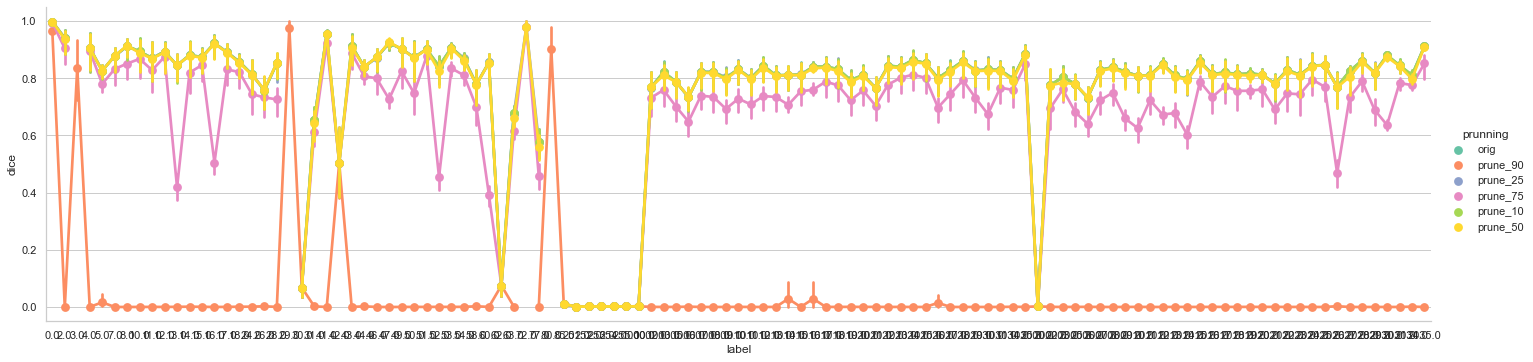

In [7]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', kind='point', data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)


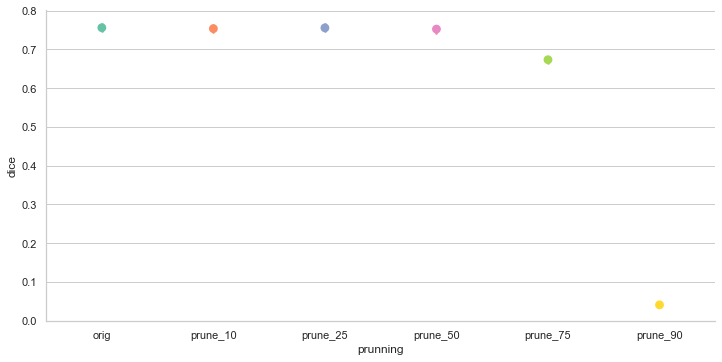

In [8]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1)
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', kind='point', data=plot_df, palette='Set2', order=x_order, height=5, aspect=2, sharex=True, sharey=True)
